In [1]:
import re

In [73]:
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random

# Reading the Facebook Graph

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910


(0.0, 1.0, 0.0, 1.0)

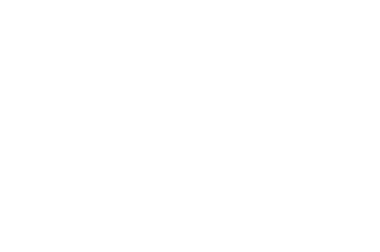

In [5]:
g = nx.read_edgelist('/Users/user/Desktop/node2vec-master/graph/facebook_combined.txt', create_using=nx.Graph(), nodetype=int)
print(nx.info(g))
sp=nx.spring_layout(g)
plt.axis('off')

# Processing the embeddings from Node2Vec

In [6]:
all_values = pd.read_csv('facebook.emd')['4039 128'].values
fb_dict = {'node_id': [], 'embedding': []}

for v in all_values:
    v_split = [float(x) for x in v.split(' ')]
    fb_dict['embedding'] += [v_split[1:]]
    fb_dict['node_id'] += [int(v_split[0])]

fb_df = pd.DataFrame.from_dict(fb_dict)

In [7]:
fb_df.head()

,embedding,node_id
0,"[-0.03462, 0.14721, 0.085802, -0.023518, -0.28...",3437
1,"[0.278259, 0.203138, 0.176665, 0.045982, -0.14...",107
2,"[0.357548, -0.144361, 0.40464, 0.335708, -0.14...",1684
3,"[-0.089028, -0.028927, -0.02356, -0.340999, 0....",0
4,"[-0.173345, 0.266669, 0.301875, -0.135857, -0....",1912


## Experiment 1: Clustering

### Q1: Are the nodes who took the survey the k-means center of the embedding space?

In [8]:
embeddings_X = np.array([np.array(x) for x in fb_df['embedding'].values])
kmeans = KMeans(n_clusters=10, random_state=0).fit(embeddings_X)
centroids = {}
for i in range(len(kmeans.cluster_centers_)):
    c_id = 'c_id_' + str(i)
    centroids[c_id] = []
    for e in fb_df['embedding'].values:
        centroids[c_id] += [np.linalg.norm(kmeans.cluster_centers_[i] - e)]

In [9]:
centroids = {}
for i in range(len(kmeans.cluster_centers_)):
    c_id = 'c_id_' + str(i)
    centroids[c_id] = []
    for e in fb_df['embedding'].values:
        centroids[c_id] += [np.linalg.norm(kmeans.cluster_centers_[i] - e)]
for k in centroids.keys():
    fb_df[k] = centroids[k]

In [10]:
cluster_to_node = {}
for label in fb_df.dtypes.index.values:
    if 'c_id' in label:
        cluster_to_node[label] = fb_df.sort_values(label)['node_id'].values[0]
cluster_to_node.values()

dict_values([761, 2530, 1775, 206, 3746, 3163, 3323, 1147, 558, 3996])

In [11]:
cluster_to_node

{'c_id_0': 3323,
 'c_id_1': 206,
 'c_id_2': 3746,
 'c_id_3': 2530,
 'c_id_4': 1147,
 'c_id_5': 761,
 'c_id_6': 558,
 'c_id_7': 3163,
 'c_id_8': 3996,
 'c_id_9': 1775}

In [12]:
survey_nodes = [107, 1684, 1912, 3437, 0, 348, 3980, 414, 686, 698]
survey_nodes

[107, 1684, 1912, 3437, 0, 348, 3980, 414, 686, 698]

### Q2: Are the nodes who took the survey significantly closer to a centers than other nodes ?

In [13]:
def node_dist(emb1, emb2):
    return np.linalg.norm(emb1 - emb2)

In [63]:
survey_to_centroid = []
for node in survey_nodes:
    node_emb = fb_df.loc[fb_df['node_id'] == node]['embedding'].values[0]
    survey_to_centroid += [min([node_dist(node_emb, centroid_i) for centroid_i in kmeans.cluster_centers_])]

In [92]:
average_to_centroid = []

for boot_strap in range(1000):
    # sampling random nodes
    random_nodes = []
    while len(random_nodes) != 10:
        r_node = random.choice(fb_df['node_id'].values)
        if r_node not in survey_nodes:
            random_nodes += [r_node]

    # measuring average distance to closest centroid
    random_to_centroid = []
    for node in random_nodes:
        node_emb = fb_df.loc[fb_df['node_id'] == node]['embedding'].values[0]
        random_to_centroid += [min([node_dist(node_emb, centroid_i) for centroid_i in kmeans.cluster_centers_])]

    average_to_centroid += [np.mean(random_to_centroid)]

In [93]:
# p-value of the Null Hypothesis: survey nodes are closer to the centroids that other nodes
p_value = np.mean(np.mean(survey_to_centroid) < average_to_centroid)
p_value

0.245

## Experiment 2: Semantic interpretation of Embeddings

In [110]:
def node_sum(node1, node2):
    """Takes in two nodes and returns the node whose embedding is closest to the sum of their embeddings"""
    node1_e = np.array(fb_df.loc[fb_df['node_id'] == node1]['embedding'].values[0])
    node2_e = np.array(fb_df.loc[fb_df['node_id'] == node2]['embedding'].values[0])
    sum_n1_n2 = node1_e + node2_e
    fb_df['dist to n12'] = [node_dist(sum_n1_n2, n) for n in fb_df['embedding'].values]
    closest_node = fb_df.sort_values('dist to n12')['node_id'].values[0]
    return closest_node